In [0]:
%matplotlib inline

# Siema!
## Warsztat KNUM 30.05.2019.
Zadanie: klasyfikacja zdjęć ze zbioru danych CIFAR-10
Do zrobienia:
0. Zapoznaj się ze zbiorem danych przedstawionym w pierwszych komórkach notebooka,
1. Przygotuj sieć neuronową do treningu na obrazkach,
2. Wybierz funkcję straty i optymalizator,
3. Prześledź proces trenowania, oceny wyników uczenia i spróbuj poprawić swój wynik!

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

Torchvision pozwala nam pobrać zbiór danych CIFAR-10, który jest zbiorem zdjęć przedstawiających 10 różnych klas. Po imporcie danych normalizujemy je do użytecznej postaci.


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170287104/170498071 [01:05<00:00, 6636618.08it/s]

Files already downloaded and verified


Podejrzyjmy klika zdjęć z datasetu.

truck   cat  frog  frog


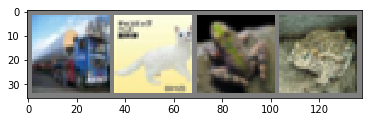

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Budowanie sieci neuronowej
---
1. Przygotuj sieć do treningu na obrazkach. Możesz poeksperymentować z ilością wartsw. Zastąp `None` odpowiednimi objektami.

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = None
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Funkcja straty i optymalizator

---

2. Wybierz funkcję straty i optymalizator. Poeksperymentuj z CrossEntropyLoss i Stochastic Gradient Descent. Zastąp `None` odpowiednimi obiektami.

In [0]:
import torch.optim as optim

criterion = None
optimizer = None

## Trening
---

Czas na wytrenowanie modelu. Uruchom komórkę, aby poznać swoje wyniki.

In [0]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

## Ewaluacja wyników na danych testowych
---

Wytrenowaliśmy nasz model przechodząc 2 razy przez zbior treningowy,
ale jeszcze nie wiemy czy nasza sieć się czegokolwiek nauczyła.

Podejrzyjmy obrazki ze zbioru testowego i zobaczmy jak zakwalifikowała je sieć neuronowa

Krok pierwszy: Podejrzyjmy obrazki i ich domyślne klasy


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Wartośći prawdziwe: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

A co sądzi o tych obrazkach nasza sieć?



In [0]:
outputs = net(images)
print(outputs)

W `outputs` znajdują się klasyfikacji dla każdego obrazka. Każda wartość sybolizuje pewność modelu względem danej klasy.
Spójrzmy na najwyższe prawdopodbieństwa (i efektywnie klasyfikacje dokonene przez nasz model)

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Jak nasza sieć daje sobie radę na całym zbiorze danych?

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Losowe przypisanie klasy dałoby nam skuteczność ok. 10%. Jak sprawuje się Twój model? ;)

Na koniec spójrzmy na dokładność przypisania do każdej z klas


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))